# Forecasting Electricity Demand with DeepAR


This notebook is tested using `Studio SparkMagic - PySpark Kernel` running on a `ml.t3.medium` instance and connected to an EMR clsuter with an `m5.xlarge` Master node and 2 `m5.xlarge` Core nodes. Please ensure that you see `PySpark (SparkMagic)` in the top right on your notebook.


In this notebook we'll utilize EMR with SageMaker's Built DeepAR Algorithm to build a forecasting model of energy consumption by 370 customers over time, based on a [dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) that was used in the academic papers [[1](https://media.nips.cc/nipsbooks/nipspapers/paper_files/nips29/reviews/526.html)] and [[2](https://arxiv.org/abs/1704.04110)].  

In particular, we will see how to:
* Prepare the dataset using a remote Spark Cluster
* Use the SageMaker Python SDK to train a DeepAR model and deploy it
* Make requests to the deployed model to obtain forecasts interactively


In [ ]:
# %load_ext sagemaker_studio_analytics_extension.magics
# %sm_analytics emr connect --cluster_id j-xxxxxxxxxxxx --auth-type None   

## Notebook Scoped Dependencies
Notebook-scoped libraries provide you the following benefits:

* Runtime installation – You can import your favorite Python libraries from PyPI repositories and install them on your remote cluster on the fly when you need them. These libraries are instantly available to your Spark runtime environment. There is no need to restart the notebook session or recreate your cluster.
* Dependency isolation – The libraries you install using EMR Notebooks are isolated to your notebook session and don’t interfere with bootstrapped cluster libraries or libraries installed from other notebook sessions. These notebook-scoped libraries take precedence over bootstrapped libraries. Multiple notebook users can import their preferred version of the library and use it without dependency clashes on the same cluster.
* Portable library environment – The library package installation happens from your notebook file. This allows you to recreate the library environment when you switch the notebook to a different cluster by re-executing the notebook code. At the end of the notebook session, the libraries you install through EMR Notebooks are automatically removed from the hosting EMR cluster.

In [ ]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
         }
}

In [3]:
sc.install_pypi_package("pyarrow==0.14.1") # install pyarrow to run vectorized UDFs

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/48/ab/8691c96c81e8a8493e26314a99efcdde97b9ed9c1e5cd705e97d15e79502/pyarrow-0.14.1-cp37-cp37m-manylinux1_x86_64.whl

You are using pip version 9.0.1, however version 22.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

# Initial Setup
In the following cells we'll performa some preliminary setup steps including:
1. Importing the sagemaker SDK library
2. Setting up variables for the execution role, bucket, and S3 location of our data and artifacts
3. Creating a schema that will be used by spark when reading the data

In [30]:
%%local
import sagemaker
from sagemaker import get_execution_role


role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket()
key_prefix = "forecasting-electricity"
s3_processed_data_location = f"s3://{bucket}/{key_prefix}/data/processed/" # location where spark will write the processed data for training

s3_input_data_location = "s3://ee-assets-prod-us-east-1/modules/183f0dce72fc496f85c6215965998db5/v1/deep-ar-electricity/LD2011_2014.csv"
schema = "date TIMESTAMP, client STRING, value FLOAT" # source data schema

Now we have all we need to preprocess the data with spark. We'll send to spark cluster the location of the input data, the S3 location of where we'd like the output to go, and the schema information

In [5]:
%%send_to_spark -i s3_input_data_location -t str -n s3_input_data_location

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 's3_input_data_location' as 's3_input_data_location' to Spark kernel

In [6]:
%%send_to_spark -i s3_processed_data_location -t str -n s3_processed_data_location

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 's3_processed_data_location' as 's3_processed_data_location' to Spark kernel

In [7]:
%%send_to_spark -i schema -t str -n schema

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'schema' as 'schema' to Spark kernel

# Data preprocessing with Apache Spark
The input dataset comes in the following format:

|    | date                | client   |   value |
|---:|:--------------------|:---------|--------:|
|  0 | 2011-01-01 00:15:00 | MT_001   |       0 |
|  1 | 2011-01-01 00:30:00 | MT_001   |       0 |
|  2 | 2011-01-01 00:45:00 | MT_001   |       0 |
|  3 | 2011-01-01 01:00:00 | MT_001   |       0 |
|  4 | 2011-01-01 01:15:00 | MT_001   |       0 |

The first column contains the timestamp of the observation in 15 min increments. The `client` column uniquely identifies each timeseries (i.e. the customer), and the `value` column provides the electricity demand at that time

For DeepAR we'll need to transform the timeseries data into a json lines format where each line contains a json object representing each client and having the following schema: <br>
`{"start": ..., "target": [0, 0, 0, 0], "dynamic_feat": [[0, 1, 1, 0]], "cat": [0, 0]}` <br>
We'll only use the `start` attribute which contains the start date for the timesries, the `target` attribute which contains the observations, and the `cat` attribute with which will encode each client as a category. DeepAR supports providing additional categorical and continuous features to improve the quality of the forecast

Here we will read the data from S3, and then use a compination of PySpark and PandasUDFs to get the data into the right format

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

import random
import pyspark.sql.functions as fn
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, ArrayType, DoubleType, StringType, IntegerType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
data = (spark
        .read
        .schema(schema)
        .options(sep =',', header=True, mode="FAILFAST", timestampFormat="yyyy-MM-dd HH:mm:ss")
        .csv(s3_input_data_location)
       )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
data.cache() # cache for faster performance

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[date: timestamp, client: string, value: float]

In [11]:
%%pretty
data.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

date,client,value
2011-01-01 00:15:00,MT_001,0.0
2011-01-01 00:30:00,MT_001,0.0
2011-01-01 00:45:00,MT_001,0.0
2011-01-01 01:00:00,MT_001,0.0
2011-01-01 01:15:00,MT_001,0.0
2011-01-01 01:30:00,MT_001,0.0
2011-01-01 01:45:00,MT_001,0.0
2011-01-01 02:00:00,MT_001,0.0
2011-01-01 02:15:00,MT_001,0.0
2011-01-01 02:30:00,MT_001,0.0


In [12]:
# resample from 15min intervals to one hour to speed up training
data = (data.groupBy(fn.date_trunc("HOUR", fn.col("date")).alias("date"),
                    fn.col("client"))
 .agg(fn.mean("value").alias("value"))
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# create a dictionary to Integer encode each client
client_list = data.select("client").distinct().collect()
client_list = [rec["client"] for rec in client_list]
client_encoder = dict(zip(client_list, range(len(client_list)))) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's visualize the timeseries data for a random subset of clients

In [14]:
random_client_list = random.sample(client_list, 6)

random_clients_pandas_df = (data.where(fn.col("client")
                                            .isin(random_client_list)) 
                                 .groupBy("date")
                                 .pivot("client").max().toPandas()
                                )
random_clients_pandas_df.set_index("date", inplace=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

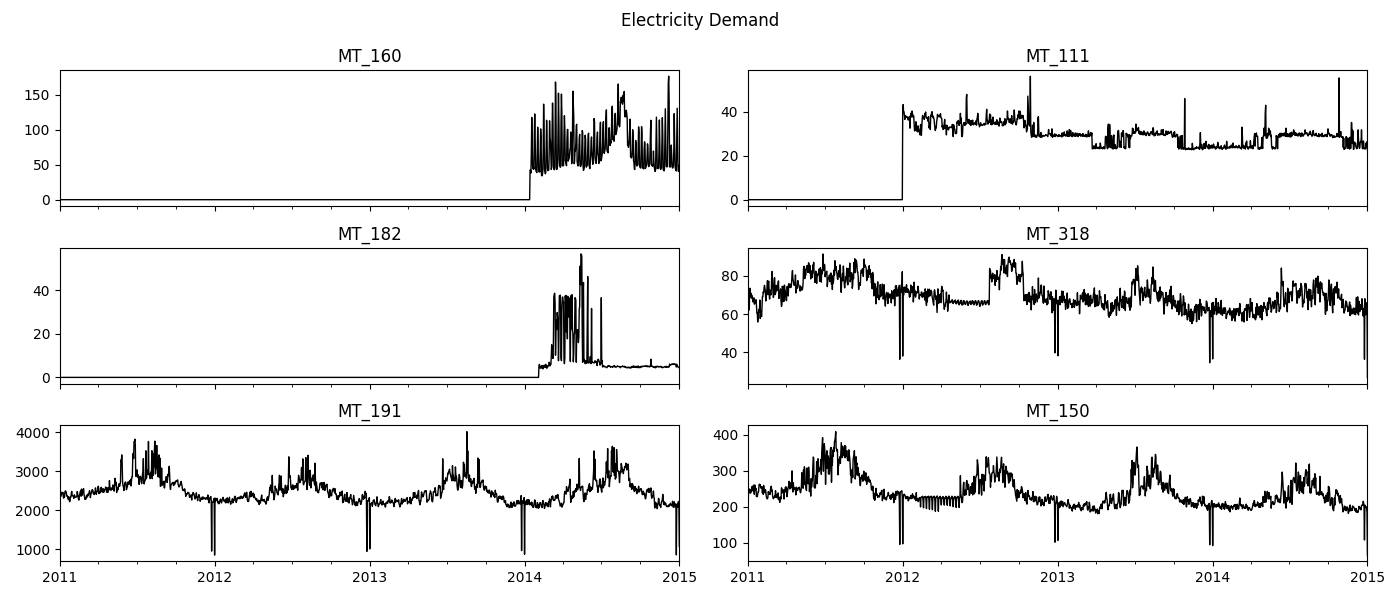

In [15]:
plt.clf()
axes = random_clients_pandas_df.resample("1D").max().plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=random_client_list,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color="k")
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle("Electricity Demand")
plt.gcf().tight_layout()

%matplot plt

DeepAR requires no gaps in your data. So for example if you have data that only comes in Monday to Friday (e.g. stock trading activity), we'd have to insert NaN data points to account for Saturdays and Sundays. A quick way to check if our data has any gaps is to aggreagte by the day of the week. Running the commands below we can see that the difference between the count and the lowest count is 24 Hours which is ok as it just means that the last datapoint falls midweek. Also the counts match accross all customers so it appears that this dataset does not have any gaps

In [16]:
weekday_counts = (data
 .withColumn("dayofweek", fn.dayofweek("date"))
 .groupBy("client")
 .pivot("dayofweek")
 .count()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
%%pretty
weekday_counts.show(5) # show aggregates for several clients
weekday_counts.agg(*[fn.min(col) for col in weekday_counts.columns[1:]]).show() # show minimum counts of observations across all clients
weekday_counts.agg(*[fn.max(col) for col in weekday_counts.columns[1:]]).show() # show maximum counts of observations across all clients

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
train_start_date = data.select(fn.min("date").alias("date")).collect()[0]["date"]
test_start_date = "2014-01-01"
end_date = data.select(fn.max("date").alias("date")).collect()[0]["date"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
print(f"overall date span: {train_start_date} to {end_date}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

overall date span: 2011-01-01 00:00:00 to 2015-01-01 00:00:00

In [20]:
# split the data into train and test set
train_data = data.where(fn.col("date") < test_start_date)
test_data = data.where(fn.col("date") >= test_start_date)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# pandasUDFs require an output schema. This one matches the format required for DeepAR
deep_ar_schema = StructType([StructField("target", ArrayType(DoubleType())),
                             StructField("cat", ArrayType(IntegerType())),
                             StructField("start", StringType())
                            ])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
@pandas_udf(deep_ar_schema, PandasUDFType.GROUPED_MAP)
def prep_deep_ar(df):
    
    df = df.sort_values(by="date")
    client_name = df.loc[0, "client"]
    targets = df["value"].values.tolist()
    cat = [client_encoder[client_name]]
    start = str(df.loc[0,"date"])
    
    return pd.DataFrame([[targets, cat, start]], columns=["target", "cat", "start"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
train_data = train_data.groupBy("client").apply(prep_deep_ar)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# Set flag so that _SUCCESS meta files are not written to S3
# DeepAR actually skips these files anyway, but it's a good practice when using directories as inputs to algorithms
spark.conf.set("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
# data is ready for DeepAR an can be written to the specified output destination
train_data.write.mode("overwrite").json(s3_processed_data_location)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%local
sagemaker.s3.S3Downloader().list(s3_processed_data_location)

# Train model with SageMaker DeepAR
Switching back to the local notebook, we can now configure a DeepAR training job <br>
We need to provide the location of the training data and specify several hyperparameters

In [27]:
%%local
from sagemaker import image_uris
image_uri = image_uris.retrieve("forecasting-deepar", sess.boto_region_name)
freq = '1H' # 1 hour frequency
prediction_length = 168  # predict one week forward
context_length = 168 # look at the past week of data
s3_output_path = f"s3://{bucket}/{key_prefix }/output"

In [28]:
%%local
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "5",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

In [31]:
%%local
deepar_estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    base_job_name="deepar-electricity-demand",
    hyperparameters=hyperparameters,
    output_path=s3_output_path
)

deepar_estimator.fit({"train": s3_processed_data_location})

2022-02-02 06:01:28 Starting - Starting the training job...
2022-02-02 06:01:45 Starting - Preparing the instances for trainingProfilerReport-1643781687: InProgress
......
2022-02-02 06:02:59 Downloading - Downloading input data
2022-02-02 06:02:59 Training - Downloading the training image......
2022-02-02 06:03:59 Training - Training image download completed. Training in progress...Arguments: train
[02/02/2022 06:04:03 INFO 139736587667072 integration.py:592] worker started
[02/02/2022 06:04:03 INFO 139736587667072] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', '

# Run Batch Inference 
Now that we have a trained model, let's setup a batch transform job. We will provide the final month of our training data (December 2013) as the input and have DeepAR forecast the first week of the test data. We will then compare the prediction against the actual values <br>
Note for DeepAR, we need to provide at a minimum of `context_length` worth of data points to get a forecast for the `prediction_length`. Providing more data during inference (ideally the enitre timeseries) could result in better predictions as DeepAR is better able to account for longer term trends

In [32]:
%%local
s3_batch_transform_input = f"s3://{bucket}/{key_prefix}/bt_input"

In [33]:
%%send_to_spark -i s3_batch_transform_input -t str -n s3_batch_transform_input

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 's3_batch_transform_input' as 's3_batch_transform_input' to Spark kernel

In [34]:
# to avoid having to recreate a DeepAR input, we'll get the index of the start date of the batch transform input and slice the target column in the train_data
bt_input_start = "2013-12-01 00:00:00"
date_range = pd.date_range(train_start_date, end_date, freq="1H") # date range for the entire dataset
bt_start_index = date_range.get_loc(bt_input_start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
bt_input_data = train_data.select(fn.lit(bt_input_start).alias("start"), 
                                  fn.col("cat"),
                                  fn.slice("target", bt_start_index, 10_000).alias("target"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
bt_input_data.write.mode("overwrite").json(s3_batch_transform_input)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
%%local
s3_bt_output_path = f"s3://{bucket}/{key_prefix}/bt_output"

deepar_transformer = deepar_estimator.transformer(instance_count=1,
                                                  instance_type="ml.m5.xlarge",
                                                  strategy="SingleRecord",
                                                  assemble_with="Line",
                                                  accept="application/jsonlines",
                                                  output_path= s3_bt_output_path
                                                 )

In [38]:
%%local
deepar_transformer.transform(s3_batch_transform_input, 
                             content_type="application/jsonlines", 
                             join_source="Input", 
                             split_type="Line",
                             logs=False)

.......................................................................!


In [39]:
%%send_to_spark -i s3_bt_output_path -t str -n s3_bt_output_path

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 's3_bt_output_path' as 's3_bt_output_path' to Spark kernel

In [40]:
bt_output = spark.read.json(s3_bt_output_path) # read batch transform output from S3

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Visualize Forecast Results

In [41]:
def plot_forecast(client, actual, time_range, predictions):
    
    
    p10 = predictions['quantiles']['0.1']
    p25 = predictions['quantiles']['0.2']
    p50 = predictions['quantiles']['0.5']
    p75 = predictions['quantiles']['0.8']
    p90 = predictions['quantiles']['0.9']
    prediction = predictions['mean']
    
    fig, ax = plt.subplots(figsize=(14,6))
    ts = ax.plot(time_range[-prediction_length:], prediction,  label="Prediction", marker="o")
    ts = ax.plot(time_range[:len(actual)], actual, label="Actual", marker="X")
    ax.fill_between(time_range[-prediction_length:], p10, p25, alpha=0.5, label="P10-P20", color="#2A9D8F")
    ax.fill_between(time_range[-prediction_length:], p25, p75, alpha=0.5, label="P20-P80", color="#E9C46A")
    ax.fill_between(time_range[-prediction_length:], p75, p90, alpha=0.5, label="P80-P90", color="#E76F51")
    ax.legend(loc="best")
    
    ax.set(title=f"{client} Electricity Demand Forecast", xlabel="date", ylabel="demand")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

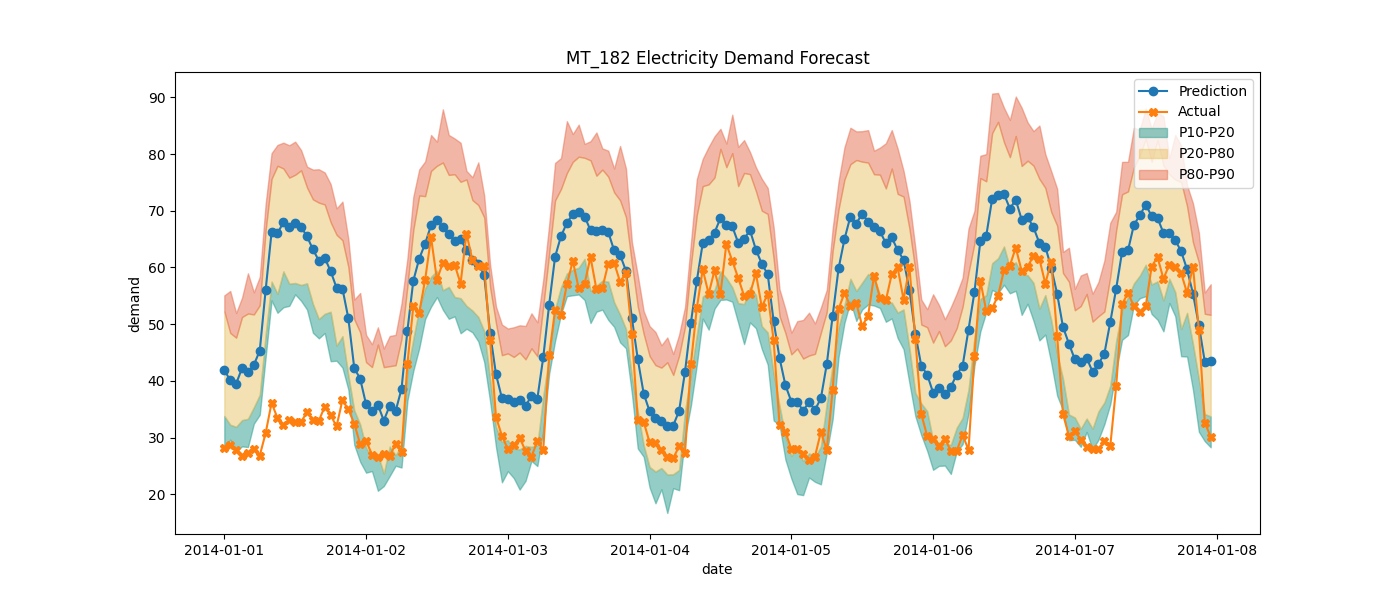

In [42]:
# let's visualize the forecast of a single random customer and compare against the actual values
rnd_client, rnd_client_enc = random.choice(list(client_encoder.items()))
forecast = bt_output.filter(fn.col("cat")[0] == rnd_client_enc).collect()[0]["SageMakerOutput"].asDict()
prediction_length = len(forecast["mean"])

forecast_start_index = date_range.get_loc(test_start_date).start
forecast_end_index = forecast_start_index + prediction_length
forecast_date_range = date_range[forecast_start_index:forecast_end_index]
forecast_date_range_str = list(map(str, forecast_date_range.to_list()))
actual_values = (data
     .where((fn.col("client") == rnd_client) & 
            (fn.col("date").isin(forecast_date_range_str)))
     .orderBy("date")
     .toPandas()
    )["value"].values.tolist()

plt.clf()
plot_forecast(rnd_client, actual_values, forecast_date_range, forecast)
%matplot plt

# Cleanup
For clean up we'll delete all of the data and outputs from S3

In [ ]:
%%cleanup -f